# Data Transformation 3: Data Cleaning
1. Hygiene for Cleaning
1. Outlier detection and handling
1. Imputation (missing values)
1. String proximity and Entity Resolution


## Hygiene for Data "Cleaning"
The very term "data cleaning" is problematic.
- Presumes that the raw data is "truly" dirty. We don't know that.
- We are inherently imposing a model over the data
- Let us not impose our will on the raw data!

Better to think of today's tasks as Transformation functions!
- With recorded input and output
- And the "lineage" of how the output is computed

### Embrace some simple metadata 
If you are transforming just one column
- Keep the original column
- Add a derived column one to the right if possible
- Name the derived column something meaningful

If you are transforming much of a data set
- Create a new derived dataset and store it "near" the original
  - filesystem directory, database schema, git repo, etc
- Name the derived dataset something that hints at the lineage

In all cases, keep the transformation code!
- Manage/version it as you would source code
- Document it as you would source code
- Hopefully in the same repository/toolchain as the data

We'll talk more about metadata and data lineage later in the semester.

# Outlier Detection and Handling
What is an "outlier"?

## Normal Distribution
Center and dispersion (spread).
- Center: mean
- Dispersion: stddev

Outliers are values with "high" spread from the center.

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# Fig size
plt.rcParams["figure.figsize"]=12,8

## replace the database connection with a database of your own!
%reload_ext sql
%sql postgresql://jmh@localhost:5432/jmh

## Normal Distributions are nice
Let's set up a good old-fashioned univariate Gaussian (normal) in SQL:

 * postgresql://jmh@localhost:5432/jmh
Done.
 * postgresql://jmh@localhost:5432/jmh
1000 rows affected.
 * postgresql://jmh@localhost:5432/jmh
1000 rows affected.


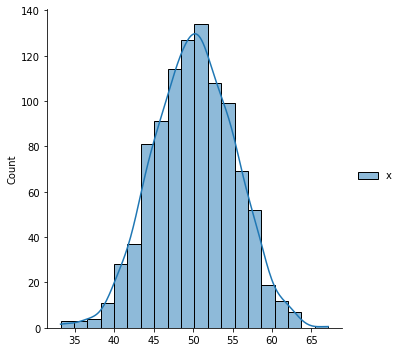

In [2]:
%sql DROP TABLE IF EXISTS observations CASCADE;
%sql CREATE TABLE observations AS \
     SELECT normal_rand AS x FROM normal_rand(1000, 50, 5);

results = %sql SELECT x FROM observations
sns.displot(results.dict(), fill=True, kde=True, bins=20)

## Detecting Gaussian Outliers
One rule of thumb: outliers are 2 stddevs ($2\sigma$) from the mean on either side.
- Based on the normal distribution, 2 stddev's is about 95% of the data
- So outliers are below p2.5 and above p97.5
- We could of course pick $3\sigma$ (99.7% of the data) or more

In [3]:
%%sql
CREATE OR REPLACE VIEW normal_outliers AS
 WITH bounds AS (
 SELECT avg(x) - 2*stddev(x) AS lo, avg(x) + 2*stddev(x) AS hi
   FROM observations
 )
 SELECT x FROM observations o, bounds b
  WHERE x NOT BETWEEN b.lo AND b.hi;
    
SELECT * FROM normal_outliers;

 * postgresql://jmh@localhost:5432/jmh
Done.
41 rows affected.


x
60.7387155185143
33.8830877466258
61.993367925147
61.7071320894362
39.3368465112033
37.7177517785581
39.7535220216723
39.592613885569
61.014036542253
60.877769264825


## Handling Gaussian Outliers
- One option is simply to *delete* the outlying values from consideration. 
- Now let's look at the data with and without outliers.

 * postgresql://jmh@localhost:5432/jmh
1959 rows affected.


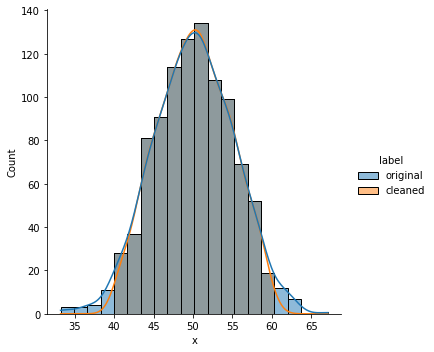

In [4]:
results = %sql SELECT x, 'original' as label FROM observations \
                UNION ALL \
               SELECT x, 'cleaned' FROM observations \
                WHERE x NOT IN (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist', hue='label', kde=True, bins=20)

## Non-Gaussian Data
What if you corrupt just one value to be very large? 
- Right-biased: not a normal distribution anymore! 
- Messes up "textbook" definitions of center and dispersion!
    - They assumed a Gaussian distribution

In [5]:
## corrupt one value
%sql UPDATE observations SET x = x*10 \
      WHERE x = (SELECT MAX(x) FROM OBSERVATIONS);

 * postgresql://jmh@localhost:5432/jmh
1 rows affected.


[]

### What Happened??

In [12]:
%%sql
SELECT avg(x), stddev(x), 'dirty' as label FROM observations
UNION ALL 
SELECT avg(x), stddev(x), 'clean' as label FROM observations WHERE x < 500;

 * postgresql://jmh@localhost:5432/jmh
2 rows affected.


avg,stddev,label
50.7280186588016,20.2782438148368,dirty
50.1069212377139,5.04684672743716,clean


## Masking
The $10x$ value is *masking* our earlier outliers
- Even the one on the left!
- We can mask any outlier we please with an even bigger outlier!

Gaussian definitions of "center" and "dispersion" are not **robust**
  - 1 value can drag the mean and stddev *as far as you want*!

Robust measures should tolerate some corruption
  - after all, the whole point is to handle dirty data!
  - we'll define robustness formally shortly

## Trimming: Percentile Outliers
- Suppose we define the outliers by order statistics (percentiles)
- *Trimming*: dropping outliers based on order statistics
- E.g. a "1% trimmed distribution" drops the 1% on either end
  - p1 and p99.

 * postgresql://jmh@localhost:5432/jmh
Done.
 * postgresql://jmh@localhost:5432/jmh
1000 rows affected.
 * postgresql://jmh@localhost:5432/jmh
1000 rows affected.


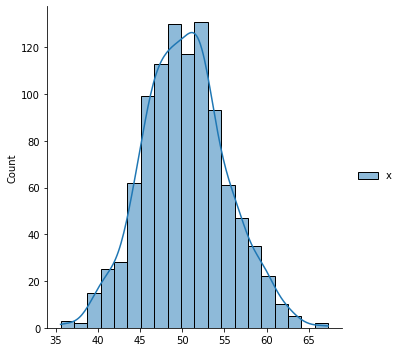

In [13]:
%sql DROP TABLE observations CASCADE;
%sql CREATE TABLE observations AS SELECT normal_rand AS x FROM normal_rand(1000, 50, 5);

results = %sql SELECT x FROM observations
sns.displot(results.dict(), fill=True, kde=True, bins=20)

In [14]:
%%sql
CREATE OR REPLACE VIEW p1p99 AS
SELECT percentile_cont(.01) WITHIN GROUP (ORDER BY x) AS p1,
       percentile_cont(.99) WITHIN GROUP (ORDER BY x) AS p99
      FROM observations;
SELECT * FROM p1p99;

 * postgresql://jmh@localhost:5432/jmh
Done.
1 rows affected.


p1,p99
39.6869497711508,62.1590327367258


In [15]:
%%sql
CREATE OR REPLACE VIEW trimmed_observations AS
SELECT o.x, 'trimmed' AS label
  FROM observations o, p1p99 p
 WHERE o.x BETWEEN p.p1 AND p.p99
UNION ALL
SELECT o.x, 'original' AS label
  FROM observations o;

CREATE OR REPLACE VIEW trimmed_outliers AS
SELECT o.*
  FROM observations o, p1p99 p
 WHERE o.x NOT BETWEEN p.p1 AND p.p99;

 * postgresql://jmh@localhost:5432/jmh
Done.
Done.


[]

 * postgresql://jmh@localhost:5432/jmh
1980 rows affected.
 * postgresql://jmh@localhost:5432/jmh
20 rows affected.


x
38.8670101878997
38.9617889922388
62.4606519370425
38.1676520489525
62.2825600526658
39.3436628764446
35.5958449832071
67.3046865938489
62.2163618205448
35.9423290068545


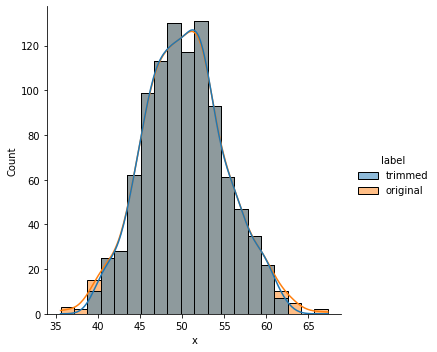

In [16]:
results = %sql SELECT * from trimmed_observations
sns.displot(results.dict(), x="x", kind='hist', hue='label', kde=True, bins=20)

results = %sql SELECT x from trimmed_outliers
results


What if you corrupt just one value to be very large? 

In [17]:
%sql UPDATE observations SET x = x*10 WHERE x = (SELECT MAX(x) FROM observations)

 * postgresql://jmh@localhost:5432/jmh
1 rows affected.


[]

In [28]:
# WHERE x < 500
%sql SELECT avg(x), max(x) from trimmed_observations;

 * postgresql://jmh@localhost:5432/jmh
1 rows affected.


avg,max
437.328952584829,673046.865938489


## Is Trimming More Robust than Stddev-Based?
Minor masking on the right, but not nearly as bad.

- Maybe we should have trimmed less? More? How much? Hmmm...
  - Seems like it should depend on the data!
- Before we answer that, one more standard outlier handling scheme.

## Winsorizing
- Trimming:
  - dropped the $k\%$ tails 
- Winsorizing:
  - *replace* those values with the $k$-percentile value.
  - $k\%$ tails contain the same repeated value
- This preserves the probability density of the tails.
  - usually not a big difference from trimming
    - mostly seen in the stddev, not the mean
  - Winsorize preferred to Trimming if something downstream forbids NULL

In [21]:
%%sql
CREATE OR REPLACE VIEW winsorized_observations AS
SELECT CASE WHEN o.x BETWEEN p.p1 AND p.p99 THEN o.x
            WHEN o.x < p.p1 THEN p.p1
            WHEN o.x > p.p99 THEN p.p99
        END AS x,
      'winsorized' AS label
  FROM observations o, p1p99 p
UNION ALL
SELECT o.x, 'original' AS label
  FROM observations o;

 * postgresql://jmh@localhost:5432/jmh
Done.


[]

The Winsorized distribution against the original:

 * postgresql://jmh@localhost:5432/jmh
1999 rows affected.


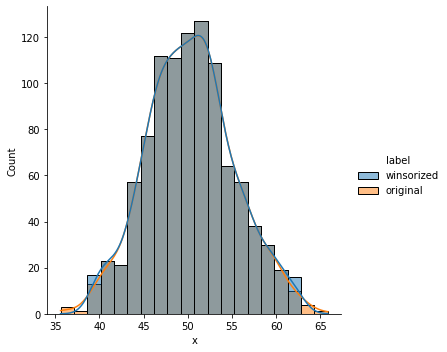

In [23]:
# WHERE x < 500
results = %sql SELECT * from winsorized_observations WHERE x < 500
sns.displot(results.dict(), x="x", kind='hist', hue='label', kde=True, bins=20)

Seems close to trimmed. Let's look more closely:

In [24]:
%%sql 
SELECT 'orig' AS distribution, min(x),
       percentile_disc(.25) WITHIN GROUP (ORDER BY x) as p25,
       percentile_disc(.50) WITHIN GROUP (ORDER BY x) as median,
       percentile_disc(.75) WITHIN GROUP (ORDER BY x) as p75,
       max(x), avg(x), stddev(x), count(x) 
       FROM observations
UNION ALL
SELECT 'winsorized', min(x),
       percentile_disc(.25) WITHIN GROUP (ORDER BY x) as p25,
       percentile_disc(.50) WITHIN GROUP (ORDER BY x) as median,
       percentile_disc(.75) WITHIN GROUP (ORDER BY x) as p75,
       max(x), avg(x), stddev(x), count(x) 
       FROM winsorized_observations WHERE label = 'winsorized'
UNION ALL 
SELECT 'trimmed', min(x),
       percentile_disc(.25) WITHIN GROUP (ORDER BY x) as p25,
       percentile_disc(.50) WITHIN GROUP (ORDER BY x) as median,
       percentile_disc(.75) WITHIN GROUP (ORDER BY x) as p75,
       max(x), avg(x), stddev(x), count(x) 
       FROM trimmed_observations WHERE label = 'trimmed';

 * postgresql://jmh@localhost:5432/jmh
3 rows affected.


distribution,min,p25,median,p75,max,avg,stddev,count
orig,35.5958449832071,46.9558258527027,50.2640049449637,53.3446328353903,673.046865938489,50.9445129734695,20.2887195338893,1000
winsorized,39.6869497711508,46.9558258527027,50.2640049449637,53.3446328353903,62.1590327367258,50.3390274800493,4.8324822982298,1000
trimmed,39.687046394502,47.0195126706792,50.2640049449637,53.2892315046379,62.1584536550711,50.3271098520108,4.60909083610677,980


## Robustness
Robustness is a worst-case analysis. So we think in terms of an *adversary*.

Suppose the adversary could "corrupt" data values arbitrarily. What does that do to an "estimator" (i.e. an aggregate like mean, stddev, etc.)?
- Defn: **Breakdown Point** of an estimator
  - smallest fraction of values the adversary must corrupt to return an *arbitrary result*
  - i.e. to change the center and spread to *whatever it wants*?
  - Depends on the definition of center and spread!

- What is the breakdown point of the $1\%$ trimmed mean?

- What $k\%$ gives us maximum robustness via trimming? 
- Could we do any better with another scheme?

### How Robust Can You Be?
The median of any distribution is maximally robust
- up to $50\%$ corruption of the data!

## Robust Estimators of a Distribution
- Center: Median
- Dispersion: the Median Absolute Deviation (MAD)

Given dataset $X$ with $\tilde X = \mbox{median}(X)$, we define the MAD as:
$$MAD(X) = \mbox{median}(|X_i - \tilde X|)$$

The Median and MAD are both maximally robust!

In [30]:
%%sql
-- percentile_disc returns an actual data value near the percentile
-- percentile_cont returns an interpolated value at the percentile
CREATE OR REPLACE VIEW median AS
(SELECT percentile_disc(0.5) WITHIN GROUP (ORDER BY x) as median
  FROM observations);

 * postgresql://jmh@localhost:5432/jmh
Done.


[]

In [31]:
%%sql
CREATE OR REPLACE VIEW mad AS
WITH
absdevs AS
(SELECT abs(x - median) as d
   FROM observations, median)
SELECT percentile_disc(0.5) WITHIN GROUP (ORDER BY d) as mad
  FROM absdevs;
    
SELECT median, mad
  FROM median, mad;

 * postgresql://jmh@localhost:5432/jmh
Done.
1 rows affected.


median,mad
50.2640049449637,3.21188578113454


## Other Robust Centers/Dispersion
You'll commonly see people use:
- center: k% trimmed mean
- center: k% winsorized mean
- dispersion: Interquartile Range (IQR: p75 - p25)

Recall the Tukey numbers for assessing univariate numerics:
- min, p25, median, p75, max: robust center/dispersion
- center: median
- spread: informed by min/max *and* IQR

## A Robust Outlier Metric: Hampel x84
Quartiles just a rule of thumb, and ignore dispersion.

Back to the earlier question: How much should we trim or winsorize?
- Let's use our intuition from the normal distribution.
- E.g. "$2\sigma$ from the mean"

### Hampel X84: Intuition from Normal
"Translate" normal estimators to robust center/dispersion.

- assume a standard normal distribution (mean 0 stddev 1)
- convert standard deviation to MADs
    - in this standard case, 1 stddev = 1.4826 MADs!
    - (Challenge: write Python or SQL to test that!)

Hampel x84: define outliers as $k*1.4826$ MADs from the median!
- benefit: outliers defined by (robust) dispersion of the data
- as opposed to IQR, etc which ignores dispersion

# Redoing our outliers with Hampel x84
Let's find/trim outliers $2*1.4826$ from the median!
- This is just like the order statistics above
- But also like $2\sigma$
  - trims based on a (robust) metric of spread

In [32]:
%%sql
CREATE OR REPLACE VIEW hampelx84x2_observations AS
SELECT o.x,
      'hampelx84x2' AS label
  FROM observations o, median, mad
 WHERE o.x BETWEEN (median-2*1.4826*mad) AND (median+2*1.4826*mad)
UNION ALL
SELECT o.x, 'orig' AS label
  FROM observations o;

CREATE OR REPLACE VIEW Hampel84x2_outliers AS
SELECT x
  FROM observations o, median, mad
 WHERE x NOT BETWEEN (median - 2*1.4826*mad) AND (median + 2*1.4826*mad);

 * postgresql://jmh@localhost:5432/jmh
Done.
Done.


[]

 * postgresql://jmh@localhost:5432/jmh
1929 rows affected.
 * postgresql://jmh@localhost:5432/jmh
58 rows affected.


x
38.8670101878997
60.7184787099983
60.2701856542196
38.9617889922388
40.3344531783919
39.9516229752939
60.1283989672611
38.1676520489525
60.8927436588279
60.1768938813435


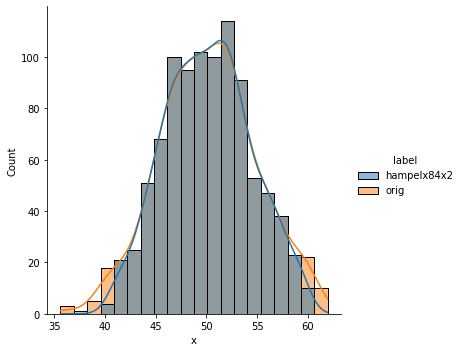

In [34]:
# WHERE x < 500
results = %sql SELECT * FROM hampelx84x2_observations WHERE x < 500
sns.displot(results.dict(), x="x", kind='hist', hue='label', kde=True, bins=20)
%sql SELECT * FROM Hampel84x2_outliers;

## Model-Based Outlier Detection
Up to now we've been cleaning stored data values. A lot of outlier detection discussion is around model fitting.

Assume you're fitting a model to your data.
- E.g. linear regression

Q: Which data points are "outliers" with respect to the model.
- "Surprising" values
- Use our outlier metrics, but apply to the *model residuals*
    - E.g. L2 distance between actual value and predicted
- Assumption: residuals of your model are normally distributed

Anything further down this path is well into the realm of data analysis, not engineering.
- So we'll stop here

## Outliers: Summing up
Detection: Center and Spread
- The normal distribution gives nice intuition, but not robust
- Robustness: want high breakdown point (at most 50%)!
- Order statistics like percentiles are robust
    - But don't take dispersion into account
- Median and MAD are robust estimators of center and dispersion, respectively
- Hampel X84: robust outlier metric, considers dispersion

Outlier Handling:
- Flagging
- Trimming
- Winsorizing
- Watch your hygiene!
  - Keep the raw data, close by
  - Document

# Data Imputation
Sometimes when data is missing, we fill in "likely" values. Why?
- Missing data can lead to bias
- Some downstream operators won't tolerate missing data
    - E.g. a stats package that needs a dense tensor

Strategies for defining what's "likely"?

- Default values for a column
    - Typically an aggregate of the column
    - E.g. the center (mean/median)
- Correlation across columns (e.g. $P(\mbox{elevation} | \mbox{latitude})$)
- Sampled from a model (possibly trained on other data)
- Interpolation across (ordered) rows

## Choice of Imputation Methods
What is a *good* imputation scheme for your setting?
- It depends!
- This is part of the art of statistics
- We will not offer prescriptions here
   - Focus on *how* rather than *what*

For purposes of illustration, let's introduce some missing values into our data.

In [1]:
## replace the database connection with a database of your own!
%reload_ext sql
%sql postgresql://jmh@localhost:5432/gnis


In [2]:
%%sql
SELECT setseed(0.12345);
DROP TABLE IF EXISTS holey CASCADE;
CREATE TABLE holey AS 
SELECT feature_id, feature_name, feature_class, state, county_name, 
       primary_latitude_dec, primary_longitude_dec, 
       CASE WHEN random() > 0.9 THEN NULL
            ELSE elevation_meters
        END AS elevation_meters
  FROM national;
SELECT count(elevation_meters)::float / count(*) FROM holey;
    

 * postgresql://jmh@localhost:5432/gnis
1 rows affected.
Done.
2290423 rows affected.
1 rows affected.


?column?
0.873135660967428


## Default Value Imputation in SQL
Two pass: i.e. an aggregate CTE followed by a query. E.g. mean imputation:

In [39]:
%%sql
WITH elevavg AS (SELECT avg(elevation_meters) FROM holey)
SELECT h.*, 
       CASE WHEN h.elevation_meters IS NOT NULL THEN h.elevation_meters
            ELSE e.avg
        END AS imputed_elevation_meters
  FROM holey h, elevavg e
 LIMIT 100;

 * postgresql://jmh@localhost:5432/gnis
   postgresql://jmh@localhost:5432/jmh
100 rows affected.


feature_id,feature_name,feature_class,state,county_name,primary_latitude_dec,primary_longitude_dec,elevation_meters,imputed_elevation_meters
1582859,Town of Brighton,Civil,WI,Kenosha,42.6261941,-88.1294900,242,242
1582860,City of Brillion,Civil,WI,Calumet,44.1756307,-88.0710399,None,498.5180373528014601
1582861,Town of Brillion,Civil,WI,Calumet,44.1992999,-88.1062942,253,253
1582862,Town of Bristol,Civil,WI,Dane,43.2411804,-89.1839652,281,281
1582863,Town of Bristol (historical),Civil,WI,Kenosha,42.5306514,-88.0149261,241,241
1582864,Town of Brockway,Civil,WI,Jackson,44.2886095,-90.7621509,275,275
1582865,City of Brodhead,Civil,WI,Green,42.6168601,-89.3756133,242,242
1582866,Village of Brokaw (historical),Civil,WI,Marathon,45.0274028,-89.6572797,None,498.5180373528014601
1582867,City of Brookfield,Civil,WI,Waukesha,43.0640707,-88.1231418,262,262
1582868,Town of Brookfield,Civil,WI,Waukesha,43.0361213,-88.1595110,253,253


## Correlation Across Columns
Given a correlation model, *applying* the model (i.e. prediction) is just a scalar function!
- E.g. linear regression from longitude to elevation_meters?
- Just apply slope and intercept to longitude!

In [4]:
# Training is an aggregate function
# Here we'll train the model in SQL just for fun
result = %sql SELECT regr_slope(elevation_meters, primary_longitude_dec), regr_intercept(elevation_meters, primary_longitude_dec) FROM holey
slope, intercept = result[0]

 * postgresql://jmh@localhost:5432/gnis
1 rows affected.


In [5]:
%%sql
SELECT *,
       CASE WHEN elevation_meters IS NOT NULL THEN elevation_meters
            ELSE :slope*primary_longitude_dec + :intercept
        END AS imputed_elevation_meters
  FROM holey
 LIMIT 100;

 * postgresql://jmh@localhost:5432/gnis
100 rows affected.


feature_id,feature_name,feature_class,state,county_name,primary_latitude_dec,primary_longitude_dec,elevation_meters,imputed_elevation_meters
1582859,Town of Brighton,Civil,WI,Kenosha,42.6261941,-88.1294900,242,242
1582860,City of Brillion,Civil,WI,Calumet,44.1756307,-88.0710399,None,442.47262502947956363089
1582861,Town of Brillion,Civil,WI,Calumet,44.1992999,-88.1062942,253,253
1582862,Town of Bristol,Civil,WI,Dane,43.2411804,-89.1839652,281,281
1582863,Town of Bristol (historical),Civil,WI,Kenosha,42.5306514,-88.0149261,241,241
1582864,Town of Brockway,Civil,WI,Jackson,44.2886095,-90.7621509,275,275
1582865,City of Brodhead,Civil,WI,Green,42.6168601,-89.3756133,242,242
1582866,Village of Brokaw (historical),Civil,WI,Marathon,45.0274028,-89.6572797,None,459.09707530807794026867
1582867,City of Brookfield,Civil,WI,Waukesha,43.0640707,-88.1231418,262,262
1582868,Town of Brookfield,Civil,WI,Waukesha,43.0361213,-88.1595110,253,253


## Exercise
Compare the original data and the imputed data
- Compute the residuals
- What is the distribution of residuals?
- What do the outliers of the residuals look like?

## Model-Based Interpolation
Like the previous case, just trained on different data in advance.

Call a scalar function taking a model prediction function, passing parameters from the values in the row:
```
SELECT *,
       CASE WHEN column IS NOT NULL THEN column
            ELSE model_predict(<constants>, <columns>)
        END
  FROM table;
  ```

## Correlation across ordered rows
This typically involves a window function. A simple example is just to "fill down":

In [8]:
%%sql
-- The following doesn't work in PostgreSQL!
WITH buggy AS (
SELECT *,
       CASE WHEN elevation_meters IS NOT NULL THEN elevation_meters
            ELSE lag(elevation_meters, 1)
                 OVER (ORDER BY feature_id)
        END AS imputed_elevation_meters
  FROM holey
)
SELECT * FROM buggy LIMIT 500;

 * postgresql://jmh@localhost:5432/gnis
500 rows affected.


feature_id,feature_name,feature_class,state,county_name,primary_latitude_dec,primary_longitude_dec,elevation_meters,imputed_elevation_meters
399,Agua Sal Creek,Stream,AZ,Apache,36.4611122,-109.4784394,1645,1645
400,Agua Sal Wash,Valley,AZ,Apache,36.5461120,-109.5176069,1597,1597
401,Aguaje Draw,Valley,AZ,Apache,34.5714281,-109.2203696,1750,1750
402,Arlington State Wildlife Area,Park,AZ,Maricopa,33.2486547,-112.7735045,231,231
403,Bar X Wash,Stream,AZ,Graham,32.4709038,-109.9361853,None,231
404,Bis Ii Ah Wash,Stream,AZ,Apache,35.8750096,-109.5442721,1799,1799
405,Brawley Wash,Stream,AZ,Pima,32.4278489,-111.2906617,592,592
406,Cement Trough Canyon,Valley,AZ,Navajo,33.9950482,-110.5126118,1494,1494
407,Corn Creek Wash,Stream,AZ,Coconino,35.2725114,-110.9268068,1435,1435
408,Coyote Wash,Valley,AZ,Navajo,35.3916770,-110.7465260,1506,1506


## Using a UDA to Simulate lag(...) IGNORE NULLS

In [9]:
%%sql
-- Here's a UDA fix from
-- https://stackoverflow.com/questions/18987791/how-do-i-efficiently-select-the-previous-non-null-value
CREATE OR REPLACE FUNCTION coalesce_agg_sfunc(state anyelement, value anyelement) RETURNS anyelement AS
$$
    SELECT coalesce(value, state);
$$ LANGUAGE SQL;

CREATE AGGREGATE coalesce_agg(anyelement) (
    SFUNC = coalesce_agg_sfunc,
    STYPE  = anyelement);

 * postgresql://jmh@localhost:5432/gnis
Done.
(psycopg2.errors.DuplicateFunction) function "coalesce_agg" already exists with same argument types

[SQL: CREATE AGGREGATE coalesce_agg(anyelement) (
    SFUNC = coalesce_agg_sfunc,
    STYPE  = anyelement);]
(Background on this error at: http://sqlalche.me/e/13/f405)


## Redoing our Fill Down Imputation

In [10]:
%%sql
-- Fixed to handle repeated NULLs
WITH fixed AS (
SELECT *,
       coalesce_agg(elevation_meters) OVER (order by feature_id) AS imputed_elevation_meters
  FROM holey
)
SELECT * FROM fixed LIMIT 500;

 * postgresql://jmh@localhost:5432/gnis
500 rows affected.


feature_id,feature_name,feature_class,state,county_name,primary_latitude_dec,primary_longitude_dec,elevation_meters,imputed_elevation_meters
399,Agua Sal Creek,Stream,AZ,Apache,36.4611122,-109.4784394,1645,1645
400,Agua Sal Wash,Valley,AZ,Apache,36.5461120,-109.5176069,1597,1597
401,Aguaje Draw,Valley,AZ,Apache,34.5714281,-109.2203696,1750,1750
402,Arlington State Wildlife Area,Park,AZ,Maricopa,33.2486547,-112.7735045,231,231
403,Bar X Wash,Stream,AZ,Graham,32.4709038,-109.9361853,None,231
404,Bis Ii Ah Wash,Stream,AZ,Apache,35.8750096,-109.5442721,1799,1799
405,Brawley Wash,Stream,AZ,Pima,32.4278489,-111.2906617,592,592
406,Cement Trough Canyon,Valley,AZ,Navajo,33.9950482,-110.5126118,1494,1494
407,Corn Creek Wash,Stream,AZ,Coconino,35.2725114,-110.9268068,1435,1435
408,Coyote Wash,Valley,AZ,Navajo,35.3916770,-110.7465260,1506,1506


In [11]:
%%sql
-- Test for NULLs
WITH fixed AS (
SELECT *,
       coalesce_agg(elevation_meters) OVER (order by feature_id) AS imputed_elevation_meters
  FROM holey
)
SELECT count(*) FROM fixed WHERE imputed_elevation_meters IS NULL;

 * postgresql://jmh@localhost:5432/gnis
1 rows affected.


count
0


## General Interpolation Across Ordered Rows
This turns out to be relatively tricky/expensive: requires multiple passes over window aggs!

Our goal is to be interpolating across "runs" of NULLs.
- To interpolate, we need to label every row with
  - a unique "run" number (`run`) for each value and its subsequent NULLs
  - the initial, non-NULL value in the run (`run_start`)
  - this row's index in the run (`run_rank`)
  - the total number of rows in this run (`run_size`)
  - the next non-NULL value in order (`run_end`)

With this, we can interpolate via whatever scalar math we like (e.g. linear).

## Strategy for Interpolation
A 3-pass algorithm:
1. Forward: 
  - compute `run`
  - propagate `run_start`
  - get `nextval` into last row of run
2. Backward, given `run` partitions: 
  - compute `run_size`
  - compute `run_rank`
  - propagate `run_end` from `nextval`
3. The final query is *unordered* and just uses scalars to interpolate
  - we can just work with the order that streams out of pass 2!

Can you do better? If you don't use SQL?

<img src="files/interpolation.png">

In [12]:
%%sql
-- 1. Forward assign "run" numbers to rows, propagate val, get nextval
CREATE OR REPLACE VIEW forward AS
SELECT *,
       SUM(CASE WHEN elevation_meters IS NULL THEN 0 ELSE 1 END) 
         OVER (ORDER BY feature_id) AS run,
       coalesce_agg(elevation_meters) OVER (ORDER BY feature_id) AS run_start,
       CASE WHEN elevation_meters IS NULL 
              THEN lead(elevation_meters, 1) OVER (ORDER BY feature_id)
            ELSE NULL
             END AS nextval
  FROM holey;

SELECT * FROM forward
 LIMIT 500;

 * postgresql://jmh@localhost:5432/gnis
Done.
500 rows affected.


feature_id,feature_name,feature_class,state,county_name,primary_latitude_dec,primary_longitude_dec,elevation_meters,run,run_start,nextval
399,Agua Sal Creek,Stream,AZ,Apache,36.4611122,-109.4784394,1645,1,1645,None
400,Agua Sal Wash,Valley,AZ,Apache,36.5461120,-109.5176069,1597,2,1597,None
401,Aguaje Draw,Valley,AZ,Apache,34.5714281,-109.2203696,1750,3,1750,None
402,Arlington State Wildlife Area,Park,AZ,Maricopa,33.2486547,-112.7735045,231,4,231,None
403,Bar X Wash,Stream,AZ,Graham,32.4709038,-109.9361853,None,4,231,1799
404,Bis Ii Ah Wash,Stream,AZ,Apache,35.8750096,-109.5442721,1799,5,1799,None
405,Brawley Wash,Stream,AZ,Pima,32.4278489,-111.2906617,592,6,592,None
406,Cement Trough Canyon,Valley,AZ,Navajo,33.9950482,-110.5126118,1494,7,1494,None
407,Corn Creek Wash,Stream,AZ,Coconino,35.2725114,-110.9268068,1435,8,1435,None
408,Coyote Wash,Valley,AZ,Navajo,35.3916770,-110.7465260,1506,9,1506,None


In [15]:
%%sql
-- 2. Backward: assign run_end, run_size, run_rank
CREATE OR REPLACE VIEW backward AS
SELECT *,
       CASE WHEN elevation_meters IS NOT NULL THEN elevation_meters
            ELSE coalesce_agg(nextval) OVER (PARTITION BY run ORDER BY feature_id DESC)
        END AS run_end,
       count(*) OVER (PARTITION BY run) AS run_size,
       1 + feature_id - (min(feature_id) OVER (PARTITION BY run)) AS run_rank
  FROM forward;

SELECT * from backward LIMIT 500;

 * postgresql://jmh@localhost:5432/gnis
Done.
500 rows affected.


feature_id,feature_name,feature_class,state,county_name,primary_latitude_dec,primary_longitude_dec,elevation_meters,run,run_start,nextval,run_end,run_size,run_rank
399,Agua Sal Creek,Stream,AZ,Apache,36.4611122,-109.4784394,1645,1,1645,None,1645,1,1
400,Agua Sal Wash,Valley,AZ,Apache,36.5461120,-109.5176069,1597,2,1597,None,1597,1,1
401,Aguaje Draw,Valley,AZ,Apache,34.5714281,-109.2203696,1750,3,1750,None,1750,1,1
403,Bar X Wash,Stream,AZ,Graham,32.4709038,-109.9361853,None,4,231,1799,1799,2,2
402,Arlington State Wildlife Area,Park,AZ,Maricopa,33.2486547,-112.7735045,231,4,231,None,231,2,1
404,Bis Ii Ah Wash,Stream,AZ,Apache,35.8750096,-109.5442721,1799,5,1799,None,1799,1,1
405,Brawley Wash,Stream,AZ,Pima,32.4278489,-111.2906617,592,6,592,None,592,1,1
406,Cement Trough Canyon,Valley,AZ,Navajo,33.9950482,-110.5126118,1494,7,1494,None,1494,1,1
407,Corn Creek Wash,Stream,AZ,Coconino,35.2725114,-110.9268068,1435,8,1435,None,1435,1,1
408,Coyote Wash,Valley,AZ,Navajo,35.3916770,-110.7465260,1506,9,1506,None,1506,1,1


In [21]:
%%sql
-- 3. Simple scalar pass
CREATE OR REPLACE VIEW final AS
SELECT *, 
       run_start + (run_rank-1)*((run_end-run_start)/(run_size))
         AS interpolated
  FROM backward;

-- For purposes of examining the output, let's sort by
-- feature_id again, as we did in our first pass
-- Note that this is *not required* in step 3!
SELECT * FROM final
ORDER BY feature_id
LIMIT 500;

 * postgresql://jmh@localhost:5432/gnis
Done.
500 rows affected.


feature_id,feature_name,feature_class,state,county_name,primary_latitude_dec,primary_longitude_dec,elevation_meters,run,run_start,nextval,run_end,run_size,run_rank,interpolated
399,Agua Sal Creek,Stream,AZ,Apache,36.4611122,-109.4784394,1645,1,1645,None,1645,1,1,1645.00000000000000000000
400,Agua Sal Wash,Valley,AZ,Apache,36.5461120,-109.5176069,1597,2,1597,None,1597,1,1,1597.00000000000000000000
401,Aguaje Draw,Valley,AZ,Apache,34.5714281,-109.2203696,1750,3,1750,None,1750,1,1,1750.00000000000000000000
402,Arlington State Wildlife Area,Park,AZ,Maricopa,33.2486547,-112.7735045,231,4,231,None,231,2,1,231.00000000000000000000
403,Bar X Wash,Stream,AZ,Graham,32.4709038,-109.9361853,None,4,231,1799,1799,2,2,1015.0000000000000000
404,Bis Ii Ah Wash,Stream,AZ,Apache,35.8750096,-109.5442721,1799,5,1799,None,1799,1,1,1799.00000000000000000000
405,Brawley Wash,Stream,AZ,Pima,32.4278489,-111.2906617,592,6,592,None,592,1,1,592.00000000000000000000
406,Cement Trough Canyon,Valley,AZ,Navajo,33.9950482,-110.5126118,1494,7,1494,None,1494,1,1,1494.00000000000000000000
407,Corn Creek Wash,Stream,AZ,Coconino,35.2725114,-110.9268068,1435,8,1435,None,1435,1,1,1435.00000000000000000000
408,Coyote Wash,Valley,AZ,Navajo,35.3916770,-110.7465260,1506,9,1506,None,1506,1,1,1506.00000000000000000000


How well did PostgreSQL do? Two sorts! Could you do better?

In [19]:
%sql EXPLAIN SELECT * from final LIMIT 500;

 * postgresql://jmh@localhost:5432/gnis
11 rows affected.


QUERY PLAN
Limit (cost=1094900.83..1094934.58 rows=500 width=240)
-> Subquery Scan on backward (cost=1094900.83..1249504.38 rows=2290423 width=240)
-> WindowAgg (cost=1094900.83..1192243.81 rows=2290423 width=208)
-> WindowAgg (cost=1094900.83..1140709.29 rows=2290423 width=168)
-> Sort (cost=1094900.83..1100626.89 rows=2290423 width=136)
"Sort Key: forward.run, forward.feature_id DESC"
-> Subquery Scan on forward (cost=465366.16..539804.90 rows=2290423 width=136)
-> WindowAgg (cost=465366.16..516900.67 rows=2290423 width=136)
-> Sort (cost=465366.16..471092.21 rows=2290423 width=64)
Sort Key: holey.feature_id


## Final Notes on Imputation
- What we've discussed is standard *single imputation*
- There are fancier statistical methods even [on Wikipedia](https://en.wikipedia.org/wiki/Imputation_(statistics)):
  - E.g. *Multiple imputation* averages across multiple imputed datasets
- Getting fancier may require (even) more query gymnastics!
- You've seen enough to be dangerous!

# Entity Resolution

# Distance Functions on Strings
Which is more likely:
- "Aditya" $\rightarrow$ "Aditi"
- "Aditya" $\rightarrow$ "Adversary

We want a notion of string "distance". There are many in the literature
- [Levenshtein](https://en.wikipedia.org/wiki/Levenshtein_distance): number of single-character edits
    - Edits include insert, delete or substitute a character
- [Jaro-Winkler](https://www.postgresql.org/docs/current/fuzzystrmatch.html): another edit distance, favors similar prefixes
- Sound indexes: [Soundex](https://en.wikipedia.org/wiki/Soundex)/[Metaphone](https://en.wikipedia.org/wiki/Metaphone)/[Double Metaphone](https://en.wikipedia.org/wiki/Metaphone#Double_Metaphone)

You can get [Postgres Functions](https://www.postgresql.org/docs/current/fuzzystrmatch.html) for Levenshtein, Soundex, Metaphone and Double Metaphone

In [20]:
%%sql
SELECT levenshtein('Aditya', 'Aditi'),
       soundex('Aditya') AS soundex1, 
       soundex('Aditi') AS soundex2,
       metaphone('Aditya', 10) AS metaphone1, 
       metaphone('Aditi', 10) AS metaphone2,
       dmetaphone('Aditya') AS dmetaphone1,
       dmetaphone_alt('Aditya') AS dmetaphone_alt1,
       dmetaphone('Aditi') AS dmetaphone2,
       dmetaphone_alt('Aditi') AS dmetaphone_alt2
UNION ALL
SELECT levenshtein('Aditya', 'Adversary'),
       soundex('Aditya'), soundex('Adversary'),
       metaphone('Aditya', 10), metaphone('Adversary', 10),
       dmetaphone('Aditya'), dmetaphone_alt('Adversary'),
       dmetaphone('Aditya'), dmetaphone_alt('Adversary')
UNION ALL
SELECT levenshtein('Joe', 'Joel'),
       soundex('Joe'), soundex('Joel'),
       metaphone('Joe', 10), metaphone('Joel', 10),
       dmetaphone('Joe'), dmetaphone_alt('Joel'),
       dmetaphone('Joe'), dmetaphone_alt('Joel')


 * postgresql://jmh@localhost:5432/gnis
3 rows affected.


levenshtein,soundex1,soundex2,metaphone1,metaphone2,dmetaphone1,dmetaphone_alt1,dmetaphone2,dmetaphone_alt2
2,A330,A330,ATTY,ATT,ATT,ATT,ATT,ATT
6,A330,A316,ATTY,ATFRSR,ATT,ATFR,ATT,ATFR
1,J000,J400,J,JL,J,AL,J,AL


# Entity Resolution
A.k.a. Record Linkage, Data Matching, Deduplication, Standardization

Suppose I have a column of product names.
- Might different names represent the same real-world "entity"?

Suppose I have a table of product tuples
- Might different tuples represent the same real-world "entity"?

## Simple Case: Matching to Reference Data
Given noisy input data $D$, and a curated reference set $R$.
Map each item in $D$ to the best match in $R$ (or NULL).

Example: Suppose you have a curated table `Products`. 
- You then receive sales data from a subsidiary
- You want to match their product names to `Products`:
- Proximity join!
```
SELECT *
  FROM new_sales, products
 WHERE levenshtein(new_sales.product_name, products.name) < 5;
```
This cross join will be nightmarishly slow!
- How slow?

## Now... Fix that matching query
- So that *at most* one `products.name` is chosen per tuple of `new_sales`.

## Matching to Reference Data, Cont.
Desired: first-pass filter 
- Use a text-search index on `products.name`
    - Order of results is an approximation of ranking by distance
- Only compute levenshtein distance on top $k$ matches for each
    - Then pick the closest

Many systems provide this
- E.g. external text indexing via Elastic or the like
    - Have to keep in sync with other databases
    - Have to write the "index join" code in your application
      - b/c you are doing lookups in 2 systems: e.g. Postgres & Elastic
- E.g. in-database text indexing like Postgres' [Gin indexes](https://www.postgresql.org/docs/current/gin-intro.html)
    - Stays automatically in sync
    - Gets uses "automagically" in your SQL queries by query optimizer
      - no need to write your own "index join" code
    - Expensive on insertion
    - Not super fast compared to a custom text index

How does all that work?
- We'll return to this topic when we discuss unstructured data and search

## Entity Resolution (Without Reference Data)
Given input data $D$, partition into equivalence classes corresponding to distinct real-world entities.

Clearly a heuristic problem!

- Approach: as before, need to filter first!
  - *Blocking*: group the data into (possibly overlapping) subsets
  - *Matching*: Within each block, try to match up entities
      - *Pairwise*: Create weighted edges via distance function between pairs in a block
      - *Transitive*: Partition the resulting graph into *clusters*
          - "close" nodes should be in the same cluster
          - "distant" nodes in different clusters

## Entity Resolution 1: Blocking
Idea:
  1. Extract one or more "blocking keys" from each entity
  2. Form blocks out of entities that have same/similar blocking keys
  
Standard approach: partiton by some column(s)
  - Each group is a distinct block
  - Each item is in only one block, like GROUP BY

Fast, easy to understand/engineer.
  - Can prep data for this by derive blocking "features"
    - E.g. initials/acronyms

## Other Blocking Schemes
*Many* heuristics here. We'll learn $q$-gram blocking, mostly because $q$-grams are handy to know about anyhow.

Definition: the **$q$-grams** of a string are the substrings of length $q$.
  - E.g. trigrams of `(picasso, pablo)` are {'pic', 'ica', 'cas', 'ass', 'sso', 'so\\$', 'o\\$p', '\\$pa', 'pab', 'abl', 'blo', 'lo\\$'}
  - Handy for computing string-similarity
  - Handy for indexing: build a B-tree on $q$-grams for finding misspellings!
 
One block per distinct $q$-gram in your dataset. How to choose $q$? Heuristic.
  - $q$ too small? Most entities are in most blocks (slow! bad *precision*)
  - $q$ too big? Entities that should be together are not (bad *recall*)
  - Can extend to require matches on multiple $q$-grams
    - blows up the # of blocks, but each block smaller

## Entity Resolution 2a: Distance Metrics for Matching
- Univariate distance
  - String distances as above are limited
  - Abbreviations: IBM = International Business Machines
  - Synonyms: Eggplant = Aubergine
  - Knowledge-base hierarchies: *tangerine* is closer to *orange* than it is to *apple*
  - Upshot: there are many many heuristics in this domain!
- Multivariate (tuple) distance
  - `(Davis, Miles, 1950)`, `(Marsalis, Wynton, 1986)`, `(Davis, Miles, 1986)`
  - `(Kelloggs, Corn Flakes, 1950)`, `(Post, Shredded Wheat, 1950)`, `(Kelloggs, Corn Flakes, 2021)`

## Distance Metric Practicalities
  - In the absence of a supervised model, combine simple distance functions & weights
  - If you can get labeled data, train a model!

## Entity Resolution 2b: Clustering
Given: a block of size $b$ with $b^2$ pairwise distances
  - This is a fully-connected graph on $b$ nodes
  - Again we can heuristically threshold
    - 2 nodes close enough? Declared "same"
    - 2 nodes far enough? Prune the edge
    - Others: uncertain
  - Reasonable clustering goal (Correlation Clustering):
    - minimize the sum of intra-cluster edge weights
    - maximize the sum of inter-cluster edge weights
    - This is *intractable* (NP-Hard) in theory
    - Various approximation algorithms will do a good job
        - E.g. [Clustering Aggregation](http://cs-people.bu.edu/evimaria/cs565/aggregated-journal.pdf)

## Entity Resolution in Practice

Do-it-yourself:
1. Pick a blocking technique
    - Easy: GROUP BY on some columns
2. Pick some distance metrics
3. Call a clustering library

Use a product:
- [open source](https://www.biggorilla.org/software_cat/entity-matching/index.html) not so strong at scale
    - but with good blocking maybe scale's manageable
- various commercial tools

Be aware of products for special cases!
- mailing address deduplication
- company name deduplication
- person deduplication

## Assessing the Results of Entity Resolution

Suppose you start with 1 Million records. Your Entity Resolution software comes back with 250K entities. How well did it do?

This is a HARD PROBLEM.

- Painful to review 250,000 sets and fix by hand!
- Maybe the software can prioritize things "on the bubble"
  - items that have been put together with low confidence
  - items that have been separated with low confidence
  - requires confidence metric for the distance/clustering
- Maybe your fixes reparameterize the ER model
- An example of *Active Learning*
- Not clear that the user effort is worthwhile

## Summing Up: Entity Resolution Techniques
Basic approach:
- Blocking: many approaches (heuristics)
- Matching: 
  - Many distance functions (heuristics)
  - Many clustering techniques (heuristics)
- Assessing/Fixing results: Hard!

## Summing Up: Entity Resolution in Practice
- Entity Resolution is often very important!
- Entity Resolution is often rather dodgy 
  - Heuristics upon heuristics
  - Limited human ability to assess results
- Quite reliable in specific mature domains
  - E.g. mailing address deduplication
- Or in very general settings where training data is plentiful
  - E.g. NLP
- Or when human review is practical
  - E.g. crowd-sourceable